# <span style='color:Darkblue'>Predict Daily Minimum Temperatures</span>

#### We want to predict the minimum temperature for the next day in Melbourne, Australia, using past temperature data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'])



In [2]:
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


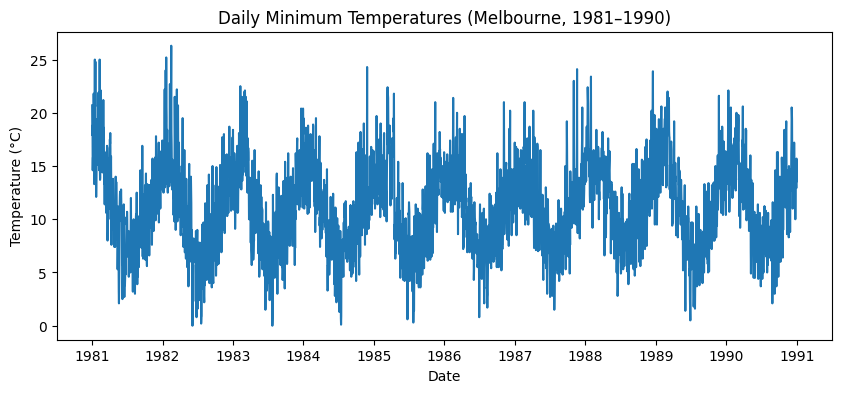

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(data['Date'], data['Temp'])
plt.title('Daily Minimum Temperatures (Melbourne, 1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data[['Temp']])

def create_sequences(dataset, lookback=7):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

lookback = 7
X, y = create_sequences(scaled, lookback)

# Split train/test (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# For RNN: reshape to [samples, timesteps, features]
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_ffn = Sequential([
    Dense(64, activation='relu', input_shape=(lookback,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ffn.compile(optimizer='adam', loss='mse')
history_ffn = model_ffn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)


C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [7]:
from tensorflow.keras.layers import LSTM

model_rnn = Sequential([
    LSTM(64, activation='tanh', input_shape=(lookback, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_rnn, y_test), verbose=0)


C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Feedforward NN MSE: 4.995
RNN (LSTM) MSE: 4.960


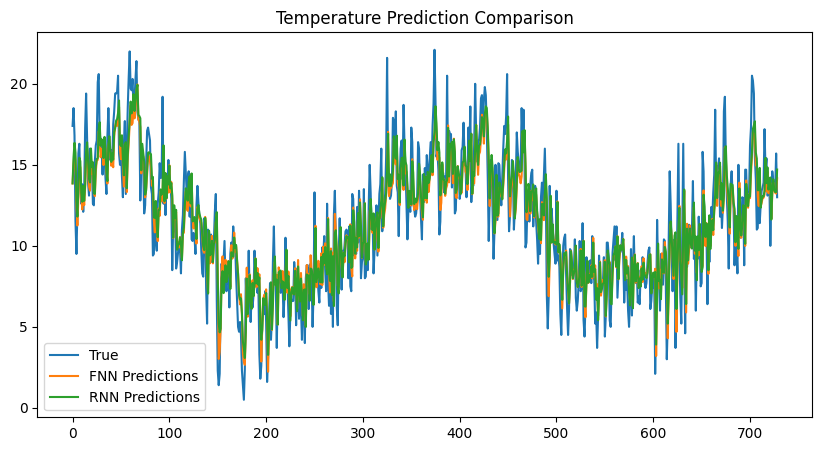

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predictions
y_pred_ffn = model_ffn.predict(X_test)
y_pred_rnn = model_rnn.predict(X_test_rnn)

# Inverse scaling
y_pred_ffn = scaler.inverse_transform(y_pred_ffn)
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# MSE
mse_ffn = mean_squared_error(y_true, y_pred_ffn)
mse_rnn = mean_squared_error(y_true, y_pred_rnn)

print(f"Feedforward NN MSE: {mse_ffn:.3f}")
print(f"RNN (LSTM) MSE: {mse_rnn:.3f}")

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True')
plt.plot(y_pred_ffn, label='FNN Predictions')
plt.plot(y_pred_rnn, label='RNN Predictions')
plt.legend()
plt.title('Temperature Prediction Comparison')
plt.show()

The plot compares actual and predicted daily minimum temperatures. The blue line shows the true values, while the orange and green lines represent predictions from the Feedforward Neural Network (FNN) and Recurrent Neural Network (RNN–LSTM), respectively. Both models closely follow the real temperature trends, successfully capturing the seasonal patterns. Their Mean Squared Error (MSE) values are nearly identical (around 5), indicating similar accuracy. The RNN’s predictions appear slightly smoother, reflecting its ability to model temporal continuity between days.